# Signal to Trading Meetup August 2018

This meetup is aimed at those with a little Python experiance to take a trading idea and turn it into a traded system with actual profit and loss.  We will be creating a simple vector based backtester to see how the trading strategy has done.  In additional we will touch on:

* Signals
* Scaling positions
* Portfolio construction
* Overall portfolio traits

The idea will be using Moskowitz et al. (2013)'s time-series momentum idea as a signal and applying, like their paper, to a limited number of futures markets.  The data will be end of day data taken from quandl.  Another good book on the topic is _Systematic Trading_ by Rob Carver.

In [15]:
# Different packages we will be using
# If don't have installed you can run in a seperate line:  "! pip install XXXX " to quickly install
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import quandl
import math
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

In [16]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Load Data from quandl

* Select a few different contracts
* Need to get contract sizes (or do we?)

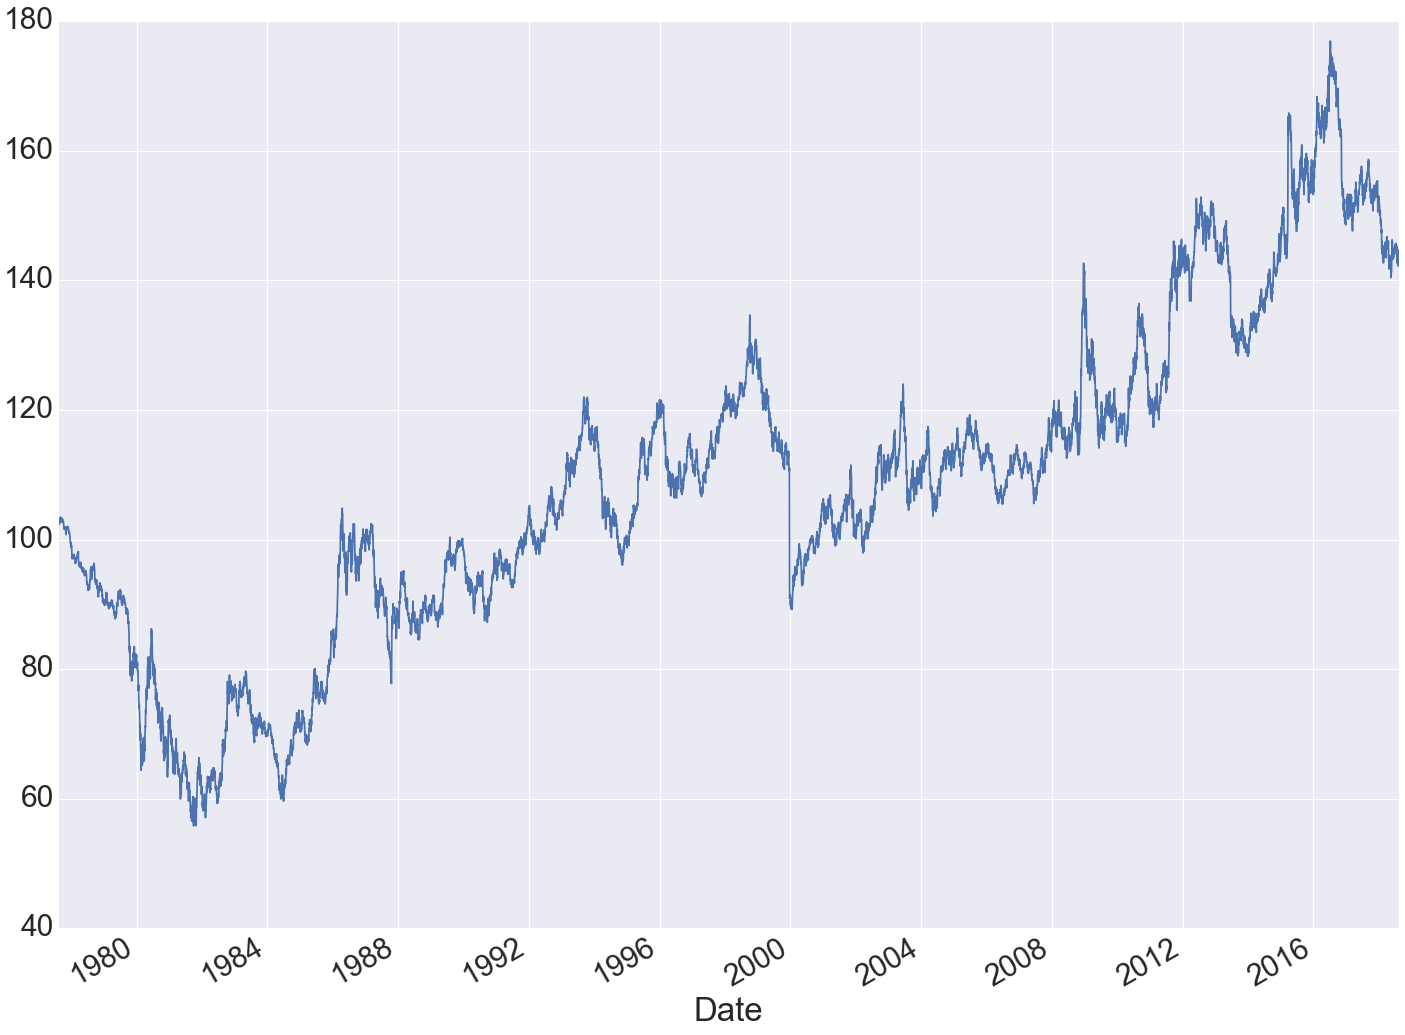

In [30]:
quandl.get("CHRIS/CME_US1", authtoken=token).Settle.plot()

In [40]:
df=pd.DataFrame()
df['SP500']=quandl.get("CHRIS/CME_SP1", authtoken=token).Settle
df['Copper']=quandl.get("CHRIS/CME_HG1", authtoken=token).Settle
df['Gold']=quandl.get("CHRIS/CME_GC1", authtoken=token).Settle
df['USD Index']=quandl.get("CHRIS/ICE_DX1", authtoken=token).Settle
df['US 10Y']=quandl.get("CHRIS/CME_US1", authtoken=token).Settle

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


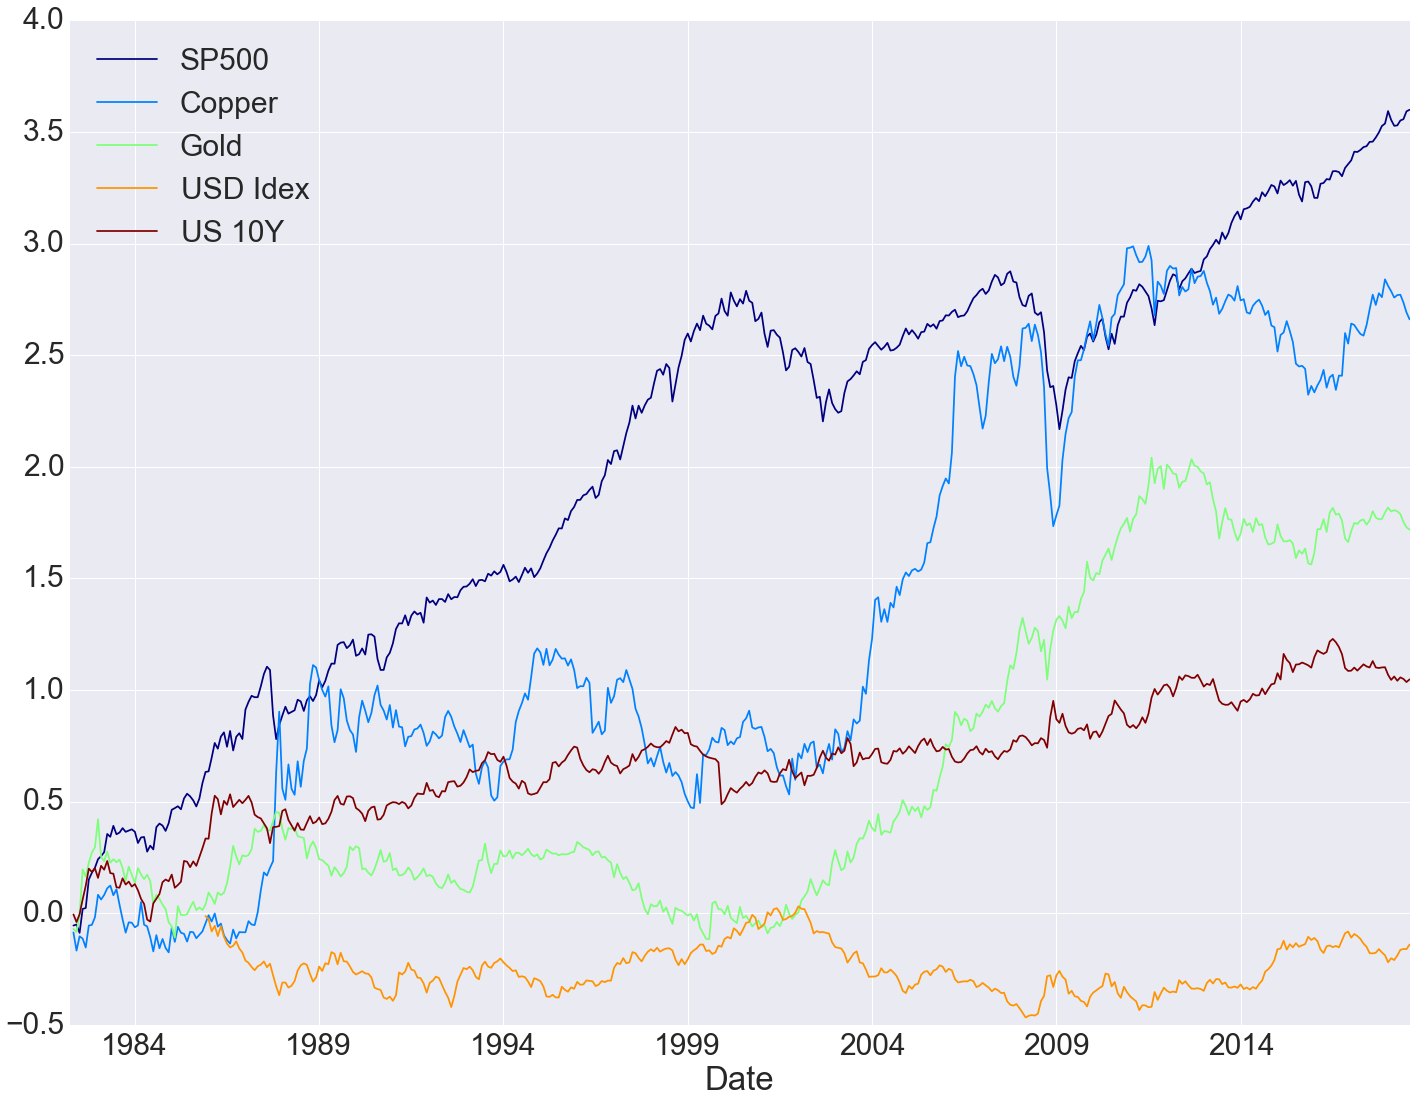

In [29]:
df.resample(rule='m',how='last').pct_change().cumsum().plot(colormap='jet')

In [41]:
price=df.resample(rule='m',how='last')
pct_rtns = price.pct_change()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


In [34]:
contract_mult=pd.Series({'SP500':50,
               'Copper': 2500,
               'Gold': 100,
               'USD Index': 1000,
               'US 10Y': 1000 })

# Signal

Moskowitz et al (2013): http://docs.lhpedersen.com/TimeSeriesMomentum.pdf

But we also need to scale each position.  As per the paper this is done by in volatility.

$$ signal = sign[r_{t-12,t}^s] $$

$$ position = \frac{Signal}{\sigma_{t-1}} $$


In [42]:

vol_lookback=20
signal_lookback=12
vol=pd.ewmstd(pct_rtns,vol_lookback,min_periods=vol_lookback)*math.sqrt(256)
signal=pd.rolling_mean(pct_rtns,signal_lookback)
signal = signal /abs(signal)
position=(signal / vol)


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=20,adjust=True,com=20).std(bias=False)
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  """


# Quick and dirty PNL 

Take the signal and shift the returns by one month and here is the pnl chart.  A couple of assumptions:

* Equal risk weighting (1/N)
* No trading cost
* No trading capital ?

Question is:

* How many lots should I take in each for $1M?
* How much volatility should I target?

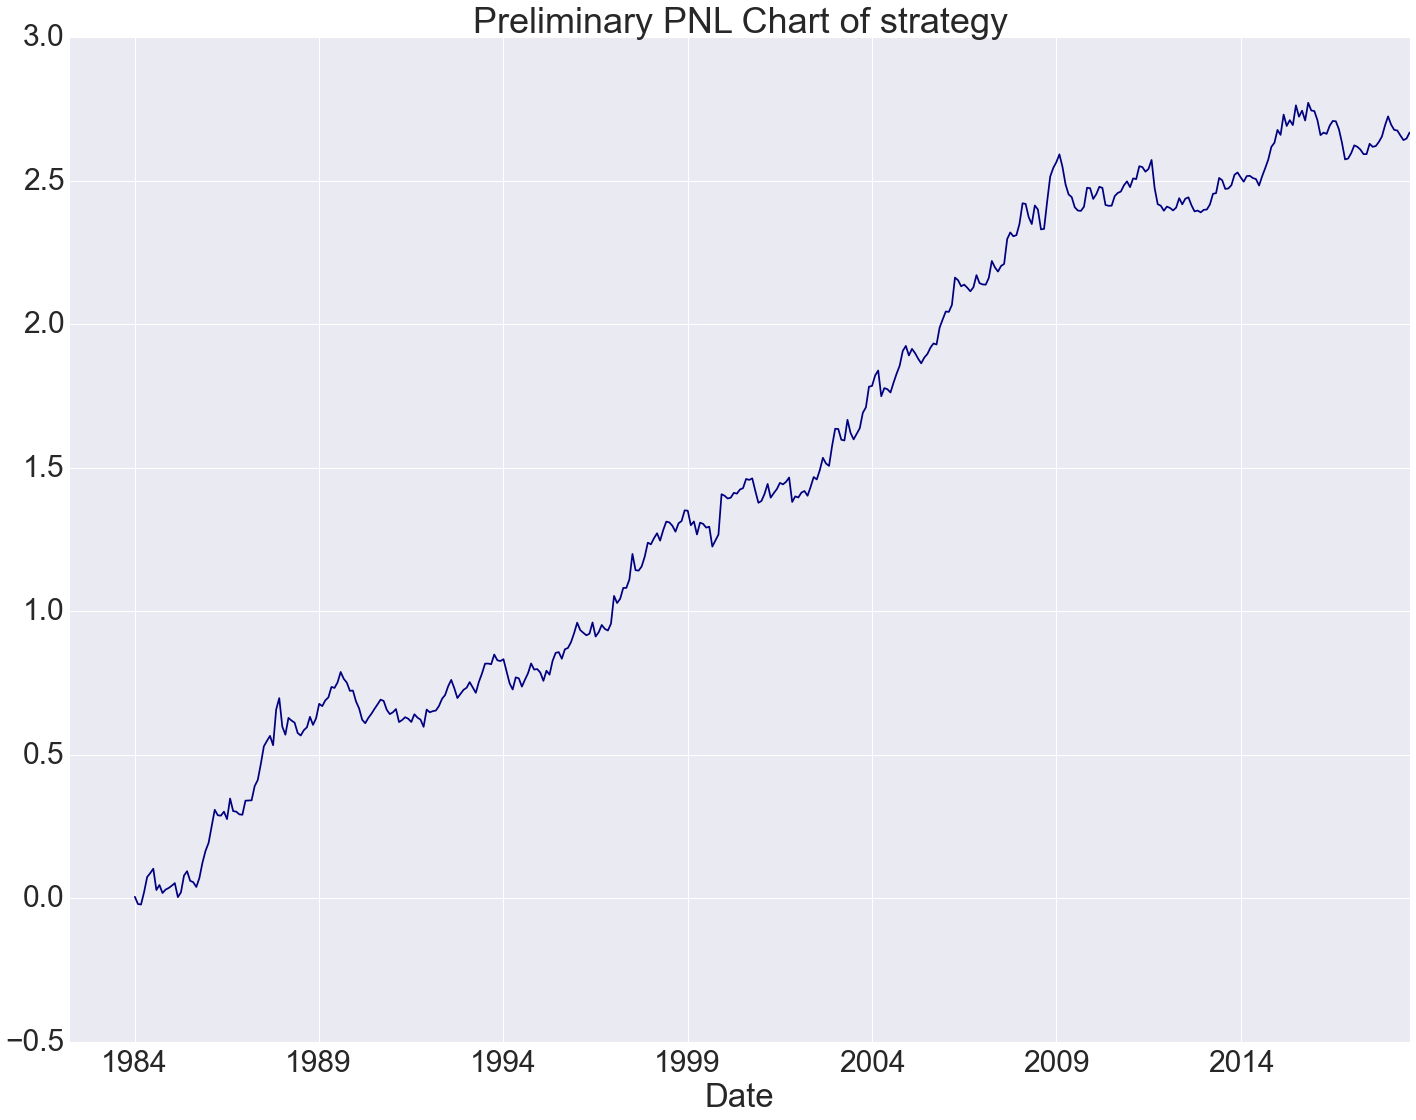

In [77]:
(position.shift()*pct_rtns).mean(axis=1).cumsum().plot(title='Preliminary PNL Chart of strategy',colormap='jet')

# Volatility Before and After


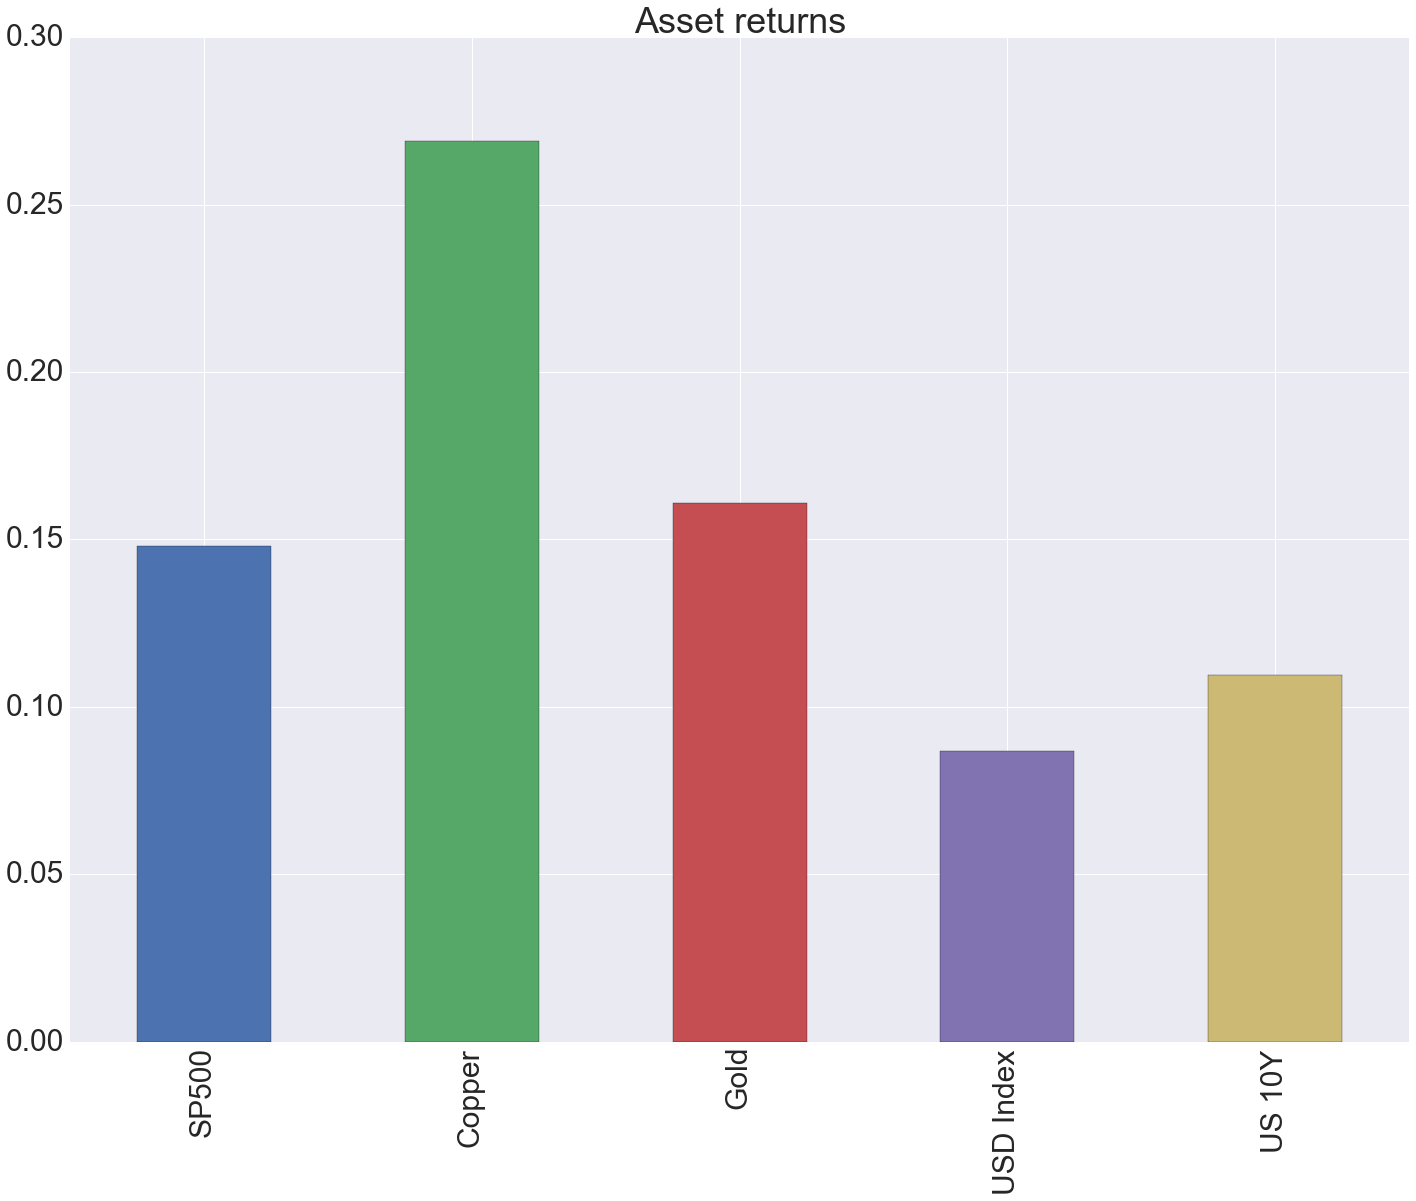

In [74]:
((pct_rtns).std()*math.sqrt(12)).plot(kind='bar',title='Asset returns')

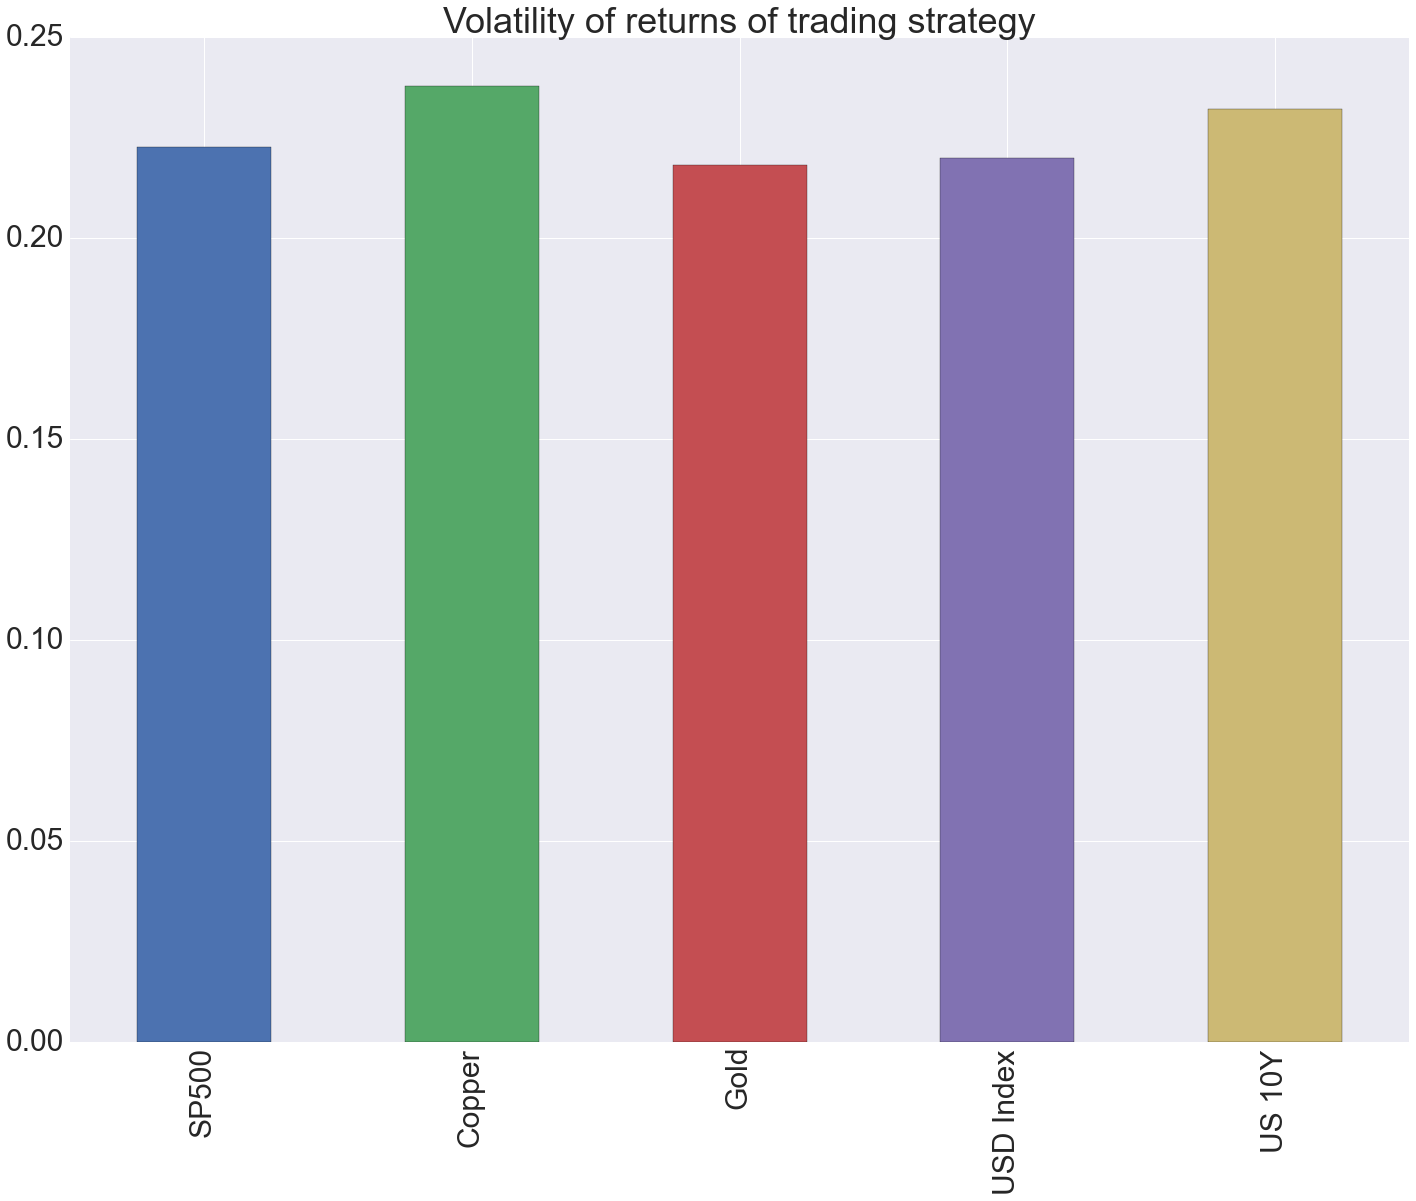

In [75]:
((position.shift()*pct_rtns).std()*math.sqrt(12)).plot(kind='bar',title='Volatility of returns of trading strategy')

# Scaling factor

Need to scale the portfolio to hit expected volatility.

$$ ScalingFactor = \frac{Target}{Expected[vol]}$$

Hard part, how do you estimate annualized expected vol.  

N.B. This is a simplistic model and we have a bit of an issue with full sample.

In [158]:
target_volatility = .2
realized_vol = (position.shift()*pct_rtns).mean(axis=1).std()*math.sqrt(12)

scaling_factor =  target_volatility / realized_vol

# Calculating position

$$ position = \frac{Signal_t*FundAUM*weight*ScalingFactor}{Price_t * ContractMultiple * FX_T}$$

In [159]:
FundAUM = 1e6
raw_position=((signal*FundAUM*scaling_factor)/(price*contract_mult))
# Equal Weighting and round positions
final_pos=(raw_position.dropna()/final_pos.count().count()).round()

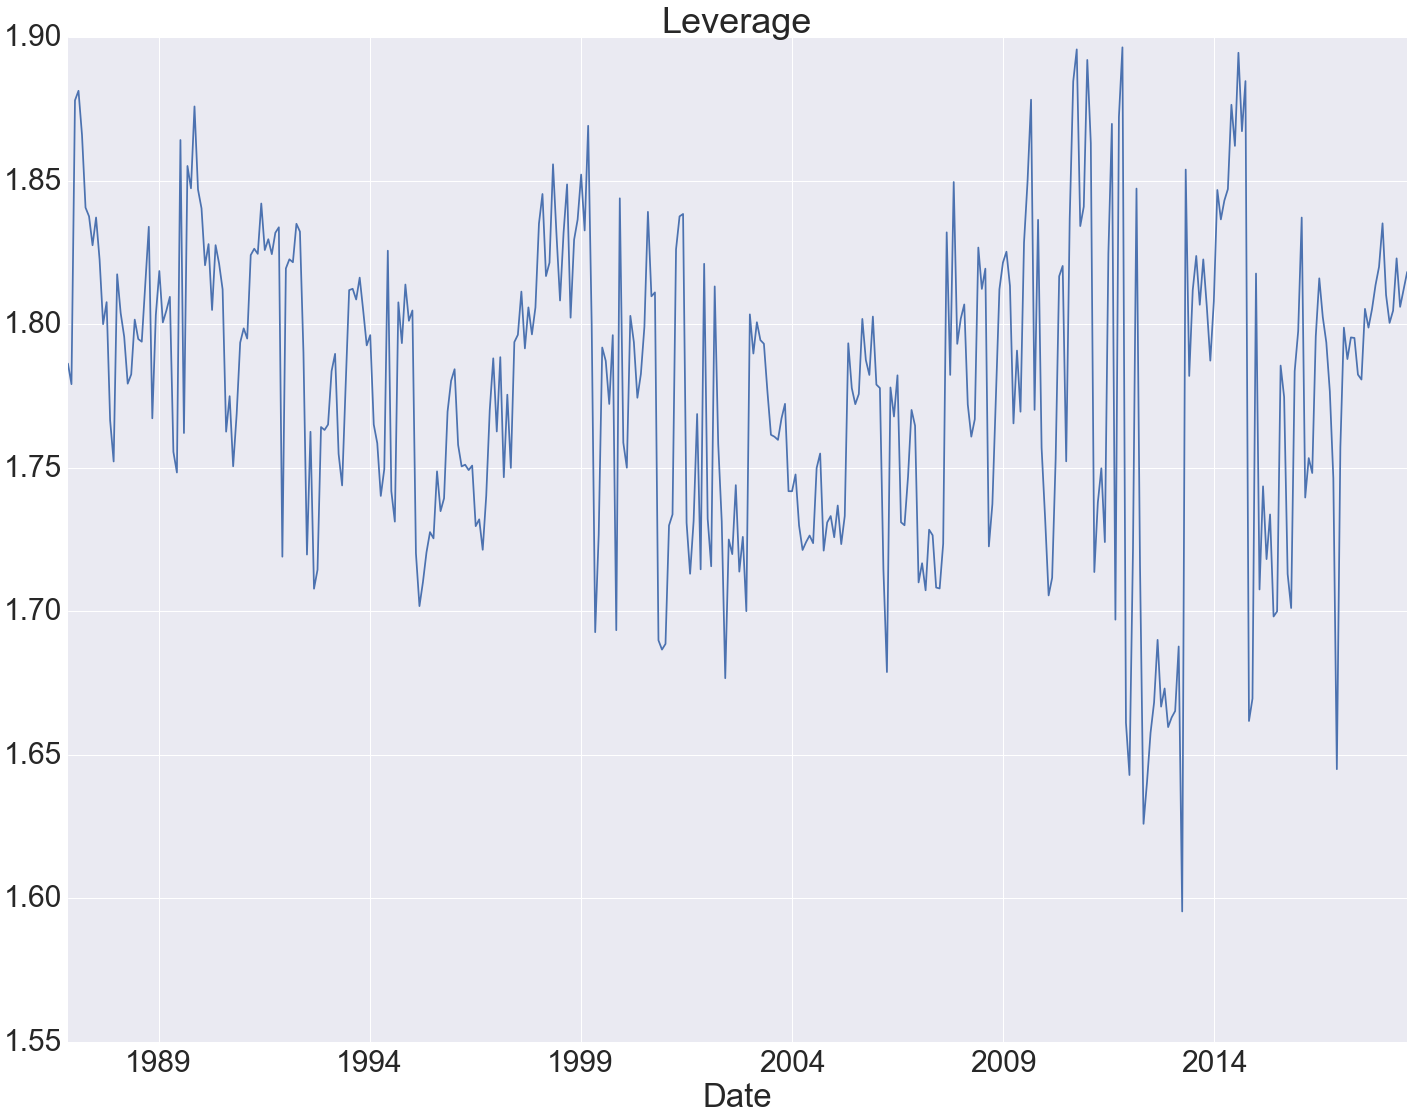

In [163]:
# Leverage calculation
((final_pos*price*contract_mult).dropna().abs().sum(axis=1)/FundAUM).plot(title='Leverage')

# Calculating PNL

Take the number of lots * price from last month and calculate the dollar return.

$$ PNL_{t} = Position_{t-1} * Price_{t-1} * ContractMultiple * MarketReturn_{t} $$

Divide the capital by the original trading capital.

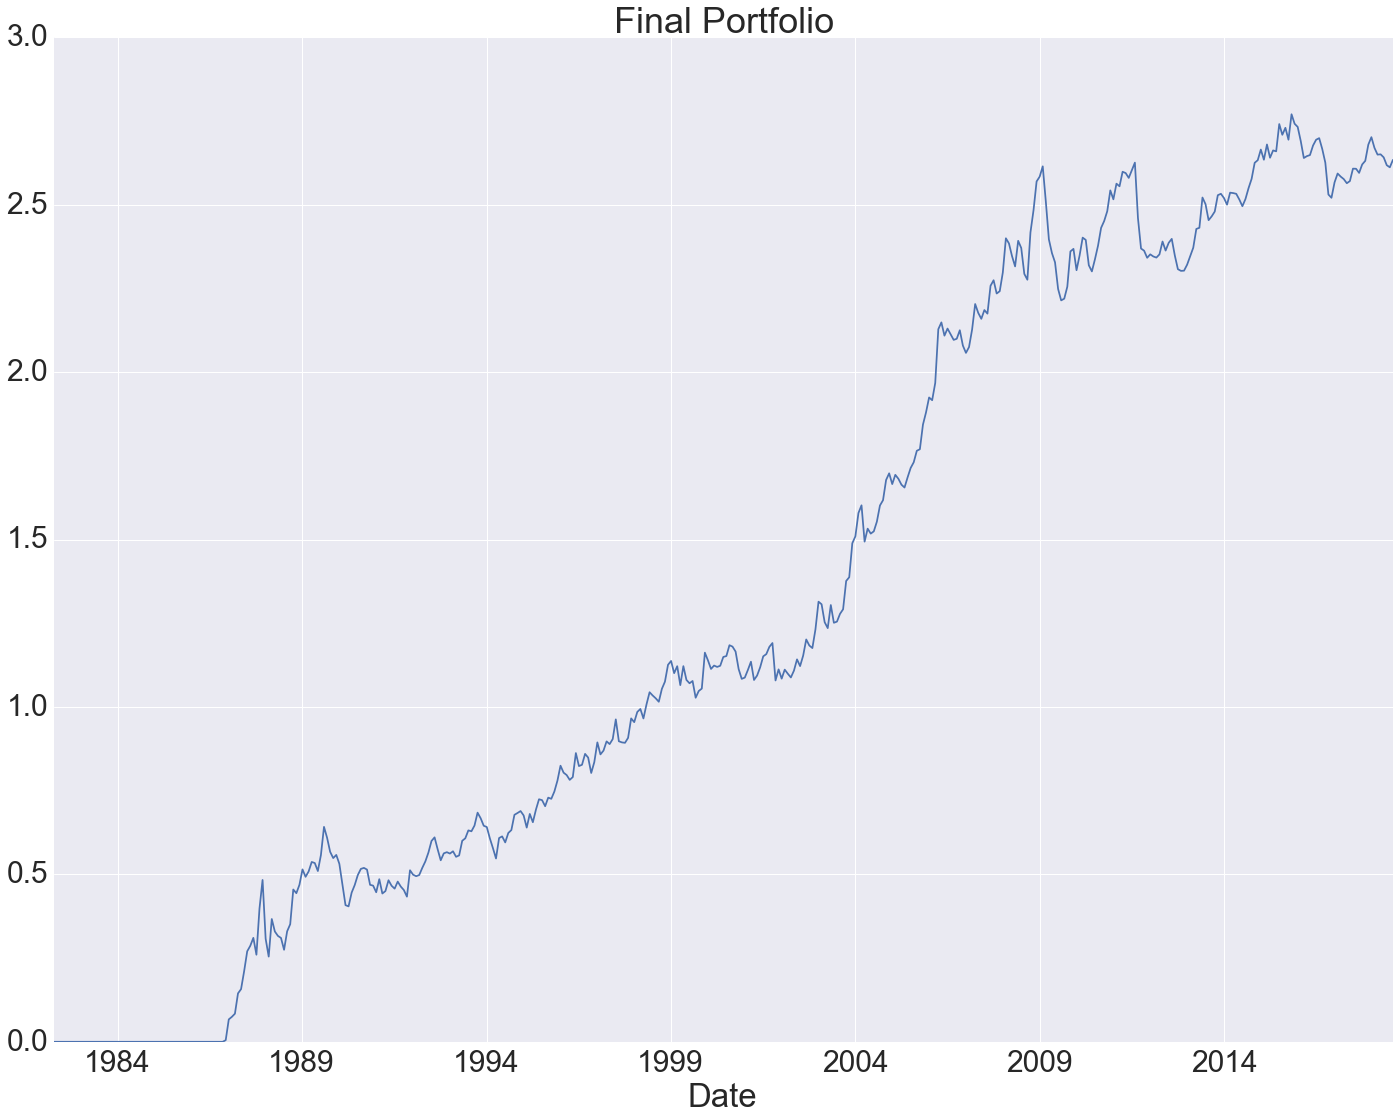

In [171]:
(((final_pos*price*contract_mult).shift()*pct_rtns).sum(axis=1)/FundAUM).cumsum().plot(title='Final Portfolio')